In [15]:
import GPy
import pickle
import numpy as np
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# generate binary input vector
def simulate_single_input(time, Dv):
    inputs = np.zeros((time, Dv))
    if Dv > 0:

        number_of_non_zero_dimenions = np.random.randint(Dv)

        non_zero_dimensions = np.random.choice(Dv - 1, number_of_non_zero_dimenions, replace=False)

        for k in non_zero_dimensions:
            start = np.random.randint(time - 1)
            end = start + 1 + np.random.randint(4, 10)
            end = min(end, time)
            inputs[start:end, k] = np.ones(end-start)

        # surgery is at the last axis
        start = np.random.randint(int(0.3 * time), int(0.6 * time))
        end = time
        inputs[start:end, -1] = np.ones(end-start)
    
    return inputs

In [17]:
def simulate_glv_with_inputs(A, g, Wv, A_g, g_g, Wv_g, inputs, N):
    Dx, Dy, _ = A_g.shape
    ndays, input_dim = inputs.shape
    tran_noise_mag = 0.01

    X = np.zeros((ndays, Dx))
    Xg = np.zeros((ndays, Dx, Dy))
    Y = np.zeros((ndays, Dy))

    log_mu = np.random.multivariate_normal(mean=np.zeros(Dx), cov=3 * np.eye(Dx))
    log_mu_g = -np.inf * np.ones((Dx, Dy))

    assert Dy % Dx == 0
    n_g_taxa = (Dy // Dx)
    for i in range(Dx):
        dim_l = n_g_taxa * i
        dim_e = n_g_taxa * (i + 1)
        log_mu_g[i, dim_l:dim_e] = np.random.multivariate_normal(mean=np.zeros(n_g_taxa), cov=3 * np.eye(n_g_taxa))

    mu = N * softmax(log_mu)
    mu_g = mu[:, None] * softmax(log_mu_g)

    for t in range(ndays):
        x_t = mu
        xg_t = mu_g
        X[t] = x_t
        Xg[t] = xg_t

        v_t = inputs[t]
        noise = np.random.normal(0.0, tran_noise_mag, Dx)
        p_t = x_t / x_t.sum()
        mu = x_t * (1 + g + Wv.dot(v_t) + A.dot(p_t) + noise)

        mu_g = np.zeros((Dx, Dy))
        for i, (xg_t_i, A_g_i) in enumerate(zip(xg_t, A_g)):
            v_t = inputs[t]
            noise = np.random.normal(0.0, tran_noise_mag, Dy)
            pg_t_i = xg_t_i / xg_t_i.sum()
            xg_tp1_i = xg_t_i * (1 + g_g + Wv_g.dot(v_t) + A_g_i.dot(pg_t_i) + noise)
            mu_g[i] = xg_tp1_i / np.sum(xg_tp1_i) * mu[i]

    for i, Xg_t in enumerate(Xg):
        print(i)
        print("\n".join([" ".join(["{:>8.0f}".format(ele) for ele in row]) for row in Xg_t]))

    Y = np.round(Xg.sum(axis=1))
    X += 1
    Xg += 1
    X = np.log(X / X.sum(axis=-1, keepdims=True))
    Xg = np.log(Xg / Xg.sum(axis=-1, keepdims=True))

    return X, Xg, Y

In [18]:
Dx = 2
Dy = 8
Dv = 0  # including surgery
n_train, n_test = 300, 20
time = 30
sparsity = 1

assert Dy % Dx == 0

# between-group interaction
A = np.random.normal(loc=0.5, scale=0.1, size=(Dx, Dx))
for i in range(Dx):
    A[i, i] = -np.abs(np.random.normal(loc=1.0, scale=0.0))
    for j in range(i + 1, Dx):
        A[i, j] = -np.abs(A[i, j])

# in-group interaction
n_g_taxa = (Dy // Dx)     # num of taxa in each group
A_g = np.zeros((Dx, Dy, Dy))
for i in range(Dx):
    dim_l = n_g_taxa * i
    dim_e = n_g_taxa * (i + 1)

    A_g[i] = np.zeros((Dy, Dy))
    # A_g[i, dim_l:dim_e, dim_l:dim_e] = np.abs(np.random.normal(loc=0.0, scale=0.2, size=(n_g_taxa, n_g_taxa)))
    A_g[i, dim_l:dim_e, dim_l:dim_e] = np.diag(np.abs(np.random.normal(loc=4.0, scale=0.1, size=(n_g_taxa))))
    A_g[i, dim_l:dim_e, dim_l:dim_e] = np.concatenate([A_g[i, dim_e - 1:dim_e, dim_l:dim_e], A_g[i, dim_l:dim_e - 1, dim_l:dim_e]], axis=0)
    for j in range(Dy):
        if dim_l <= j < dim_e:
            A_g[i, j, j] = -np.abs(np.random.normal(loc=1.0, scale=0.0))
        else:
            A_g[i, j, j] = -200
# inputs
Wv = np.random.normal(loc=0, scale=0.3, size=(Dx, Dv))
if Dv > 0:
    Wv[:, -1] = -np.abs(Wv[:, -1])
Wv_g = np.random.normal(loc=0, scale=0.3, size=(Dy, Dv))
for i in range(Dv - 1):
    n_zero_items = Dy - 2
    idxs = np.random.choice(np.arange(Dy), n_zero_items, replace=False)
    Wv_g[idxs, i] = np.zeros_like(idxs)

g = np.abs(np.random.normal(loc=0.7, scale=0.05, size=(Dx,)))
g_g = np.abs(np.random.normal(loc=0.5, scale=0.05, size=(Dy,)))

N = 10000.

print("A\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in A]))
for i, A_g_i in enumerate(A_g):
    print("A_g_{}\n".format(i) + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in A_g_i]))
print("g\n" + " ".join(["{:>5.3f}".format(ele) for ele in g]))
print("g_g\n" + " ".join(["{:>5.3f}".format(ele) for ele in g_g]))
print("Wv\n" + "\n".join([" ".join(["{:>5.2f}".format(ele) for ele in row]) for row in Wv]))

A
-1.00 -0.64
 0.51 -1.00
A_g_0
-1.00  0.00  0.00  3.94  0.00  0.00  0.00  0.00
 4.03 -1.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  3.64 -1.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  4.00 -1.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00 -200.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00 -200.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00 -200.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -200.00
A_g_1
-200.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00 -200.00  0.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00 -200.00  0.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00 -200.00  0.00  0.00  0.00  0.00
 0.00  0.00  0.00  0.00 -1.00  0.00  0.00  4.00
 0.00  0.00  0.00  0.00  4.10 -1.00  0.00  0.00
 0.00  0.00  0.00  0.00  0.00  4.09 -1.00  0.00
 0.00  0.00  0.00  0.00  0.00  0.00  3.97 -1.00
g
0.625 0.774
g_g
0.538 0.479 0.453 0.468 0.546 0.582 0.523 0.496
Wv




In [19]:
overwrite_params = False
if overwrite_params:
    with open("pairwise_interaction/clv_gp_Dx_10_Dy_10_Dv_5_s_1_Kvar_0.2_ntrain_200.p", "rb") as f:
        d = pickle.load(f)
    A = d["A"]
    g = d["g"]
    Wv = d["Wv"]
    A_g = d["A_g"]
    g_g = d["g_g"]
    Wv_g = d["Wv_g"]
    N = d["N"]
    k_var = d["k_var"]
    k_len = d["k_len"]
    
    A_r = A[:-1] - A[-1:]
    g_r = g[:-1] - g[-1:]
    Wv_r = Wv[:-1] - Wv[-1:]
    k_var = 0.0
    k_len = 1
    kernel = GPy.kern.RBF(1, variance=k_var, lengthscale=k_len)

In [20]:
# create data with missing observation
x_train = []
x_test = []
xg_train = []
xg_test = []
y_train = []
y_test = []
v_train = []
v_test = []

batch_inputs = [simulate_single_input(time, Dv) for _ in range(n_train + n_test)]

for i in range(n_train + n_test):
    v = batch_inputs[i]  # (time, Dv)
    x, xg, y = simulate_glv_with_inputs(A, g, Wv, A_g, g_g, Wv_g, v, N)
    
    # make missing observations, the first day cannot be missing
    # obs_percentage = 1.0 / sparsity
    # if int(time * obs_percentage) == time:
    #     obsed_days = np.arange(time)
    # else:
    #     obsed_days = np.random.choice(np.arange(1, time), int(time * obs_percentage) - 1, replace=False)
    #     obsed_days = np.sort(np.concatenate(([0], obsed_days)))
    obsed_days = [x for x in range(time) if x % sparsity == 0]

    x = x[obsed_days]
    xg = xg[obsed_days]
    y = y[obsed_days]

    days = np.arange(time)[:, np.newaxis]
    y = np.concatenate([days[obsed_days], y], axis=-1)
    v = np.concatenate([days, v], axis=-1)

    if i < n_train:
        x_train.append(x)
        xg_train.append(xg)
        y_train.append(y)
        v_train.append(v)
    else:
        x_test.append(x)
        xg_test.append(xg)
        y_test.append(y)
        v_test.append(v)

0
    1134       15       95       23        0        0        0        0
       0        0        0        0     2221      649      220       94
1
    1472      138      246       73        0        0        0        0
       0        0        0        0     3320     4232      770      253
2
     947      433      272       99        0        0        0        0
       0        0        0        0     2080     5522     1293      225
3
     546      698      283       95        0        0        0        0
       0        0        0        0     1436     5122     2456      226
4
     342      733      351       87        0        0        0        0
       0        0        0        0      990     3979     4040      267
5
     236      626      467       92        0        0        0        0
       0        0        0        0      699     2864     5237      387
6
     176      490      583      113        0        0        0        0
       0        0        0        0      548     2

0
     880     2074      382     2048        0        0        0        0
       0        0        0        0      233      168       34      260
1
    1356     1938      568     1505        0        0        0        0
       0        0        0        0     1882     1361      249     1015
2
    1224     1545      564      902        0        0        0        0
       0        0        0        0     2716     2883      477     1064
3
    1012     1411      593      644        0        0        0        0
       0        0        0        0     2904     4783      891     1043
4
     811     1274      658      514        0        0        0        0
       0        0        0        0     2650     6080     1680     1004
5
     654     1129      744      464        0        0        0        0
       0        0        0        0     2253     6278     3076     1021
6
     532      941      811      452        0        0        0        0
       0        0        0        0     1815     5

20
      59       80      115       92        0        0        0        0
       0        0        0        0     1080      497      357      701
21
      60       66       98      100        0        0        0        0
       0        0        0        0     1008      651      330      535
22
      67       57       80      103        0        0        0        0
       0        0        0        0      832      805      336      401
23
      78       55       65       98        0        0        0        0
       0        0        0        0      653      913      394      322
24
      86       55       53       85        0        0        0        0
       0        0        0        0      496      901      491      275
25
      90       60       45       70        0        0        0        0
       0        0        0        0      379      782      612      260
26
      86       67       41       56        0        0        0        0
       0        0        0        0      29

       0        0        0        0      888      683     1296     1935
0
     240       28      730     1398        0        0        0        0
       0        0        0        0       88      432      651      104
1
     484       28      465     1588        0        0        0        0
       0        0        0        0      494     2049     4889     1114
2
     856       30      285     1167        0        0        0        0
       0        0        0        0      544     1752     5156     2206
3
    1169       38      172      733        0        0        0        0
       0        0        0        0      653     1427     4481     3728
4
    1315       67      119      509        0        0        0        0
       0        0        0        0      909     1136     3561     5051
5
    1289      141       93      384        0        0        0        0
       0        0        0        0     1449      982     2755     5638
6
    1092      300       80      288        0      

     684      186      145      415        0        0        0        0
       0        0        0        0      611     2187     5836     1419
10
     673      271      117      293        0        0        0        0
       0        0        0        0      576     1640     4954     2398
11
     562      394      108      205        0        0        0        0
       0        0        0        0      642     1220     3820     3529
12
     428      503      117      147        0        0        0        0
       0        0        0        0      849      931     2747     4275
13
     311      546      149      112        0        0        0        0
       0        0        0        0     1301      780     2040     4318
14
     231      524      209       96        0        0        0        0
       0        0        0        0     1996      742     1515     3756
15
     175      439      287       94        0        0        0        0
       0        0        0        0     2825  

19
      54       86      187      146        0        0        0        0
       0        0        0        0      703     1623      978      378
20
      63       66      141      176        0        0        0        0
       0        0        0        0      517     1307     1256      388
21
      81       55      103      181        0        0        0        0
       0        0        0        0      401      995     1419      457
22
     111       52       78      164        0        0        0        0
       0        0        0        0      334      739     1377      588
23
     136       54       57      128        0        0        0        0
       0        0        0        0      311      557     1207      775
24
     148       65       45       96        0        0        0        0
       0        0        0        0      335      435      974      958
25
     140       85       39       72        0        0        0        0
       0        0        0        0      40

29
      96       76       80      107        0        0        0        0
       0        0        0        0      900      449      509      929
0
      16        3        6        1        0        0        0        0
       0        0        0        0     5512     1560     1167      294
1
      82       59       47       12        0        0        0        0
       0        0        0        0     3016     3313     1302      310
2
      53       79       51       14        0        0        0        0
       0        0        0        0     1447     3261     1447      236
3
      37       77       61       15        0        0        0        0
       0        0        0        0      785     2436     1821      206
4
      28       65       72       18        0        0        0        0
       0        0        0        0      467     1622     2145      225
5
      23       53       78       25        0        0        0        0
       0        0        0        0      295     

       0        0        0        0      301     1082     2998      629
9
     118      405      409       66        0        0        0        0
       0        0        0        0      309      906     2790     1224
10
      88      272      454       89        0        0        0        0
       0        0        0        0      359      714     2238     1984
11
      77      205      440      142        0        0        0        0
       0        0        0        0      493      560     1714     2530
12
      74      149      359      215        0        0        0        0
       0        0        0        0      780      487     1319     2740
13
      82      112      272      289        0        0        0        0
       0        0        0        0     1226      464      991     2454
14
     107       87      199      321        0        0        0        0
       0        0        0        0     1735      503      725     1920
15
     150       75      144      307        0

0
    1935     1722     2430      715        0        0        0        0
       0        0        0        0       44       11      170       13
1
    1365     1729     2061      840        0        0        0        0
       0        0        0        0      446      161     1088      359
2
     855     1230     1504      765        0        0        0        0
       0        0        0        0      894      379     1391     1210
3
     631      880     1164      733        0        0        0        0
       0        0        0        0     1653      666     1567     2278
4
     558      698      959      772        0        0        0        0
       0        0        0        0     2614      985     1560     2813
5
     543      575      780      791        0        0        0        0
       0        0        0        0     3617     1455     1503     2830
6
     562      493      622      764        0        0        0        0
       0        0        0        0     4251     2

28
     249      206      120      159        0        0        0        0
       0        0        0        0     1861      962     1015     1833
29
     218      226      118      128        0        0        0        0
       0        0        0        0     1971     1115      865     1450
0
      71       67       14        7        0        0        0        0
       0        0        0        0       22     2517      470     1705
1
      81      173       36       12        0        0        0        0
       0        0        0        0       75     3015     1925     2961
2
      57      169       61       11        0        0        0        0
       0        0        0        0       95     1559     2295     2596
3
      42      140       99       12        0        0        0        0
       0        0        0        0      115      852     1910     2533
4
      30      103      133       16        0        0        0        0
       0        0        0        0      154    

0
     249      109     2040      162        0        0        0        0
       0        0        0        0      763      377     1197       46
1
     614      289     2424     1089        0        0        0        0
       0        0        0        0     1666     1733     3373      271
2
     644      252     1239     1634        0        0        0        0
       0        0        0        0     1617     2673     4586      607
3
     832      222      711     1604        0        0        0        0
       0        0        0        0     1496     3008     5711     1140
4
    1092      222      436     1227        0        0        0        0
       0        0        0        0     1431     2946     6269     2017
5
    1307      273      293      867        0        0        0        0
       0        0        0        0     1447     2596     6103     3273
6
    1324      394      220      602        0        0        0        0
       0        0        0        0     1646     2

       0        0        0        0     1641     1191     2376     3749
18
     202      140      300      526        0        0        0        0
       0        0        0        0     2163     1140     1863     3460
19
     280      127      218      480        0        0        0        0
       0        0        0        0     2658     1202     1466     2881
20
     372      135      161      387        0        0        0        0
       0        0        0        0     3018     1424     1229     2297
21
     427      164      125      288        0        0        0        0
       0        0        0        0     2928     1765     1080     1742
22
     425      220      106      214        0        0        0        0
       0        0        0        0     2545     2158     1050     1328
23
     361      287       99      155        0        0        0        0
       0        0        0        0     2055     2493     1151     1048
24
     286      345      108      117        

     692     1373       23      131        0        0        0        0
       0        0        0        0     2991     7238       76      566
8
     484     1396       40       91        0        0        0        0
       0        0        0        0     2426     8151      178      455
9
     389     1318       87       74        0        0        0        0
       0        0        0        0     2115     8317      468      409
10
     317     1167      188       66        0        0        0        0
       0        0        0        0     1847     7847     1230      388
11
     249      935      370       64        0        0        0        0
       0        0        0        0     1489     6546     2806      393
12
     182      677      588       71        0        0        0        0
       0        0        0        0     1066     4711     4703      442
13
     133      468      725       97        0        0        0        0
       0        0        0        0      744    

27
       5        6       10       11        0        0        0        0
       0        0        0        0       57      112       60       29
28
       6        5        8       11        0        0        0        0
       0        0        0        0       42       94       75       28
29
       8        5        6       10        0        0        0        0
       0        0        0        0       32       75       89       31
0
      87      277        4      108        0        0        0        0
       0        0        0        0      576     1263     2535      200
1
     224      514       18      157        0        0        0        0
       0        0        0        0      819     2073     4726      658
2
     227      505       31      110        0        0        0        0
       0        0        0        0      673     1654     4335     1116
3
     197      487       54       82        0        0        0        0
       0        0        0        0      598   

17
     325      389      104      123        0        0        0        0
       0        0        0        0      741     2552     3277      521
18
     246      423      130       97        0        0        0        0
       0        0        0        0      555     1819     3585      733
19
     188      399      177       85        0        0        0        0
       0        0        0        0      476     1373     3366     1161
20
     143      337      231       84        0        0        0        0
       0        0        0        0      469     1012     2786     1753
21
     113      269      276       94        0        0        0        0
       0        0        0        0      540      759     2125     2311
22
      94      207      290      118        0        0        0        0
       0        0        0        0      716      600     1551     2542
23
      86      159      273      156        0        0        0        0
       0        0        0        0     100

       0        0        0        0     3339     8060     1171      851
7
     818      353      340      714        0        0        0        0
       0        0        0        0     2532     7937     2242      745
8
     850      423      272      538        0        0        0        0
       0        0        0        0     1896     6742     4058      746
9
     786      540      243      410        0        0        0        0
       0        0        0        0     1371     4943     5910      880
10
     658      655      242      308        0        0        0        0
       0        0        0        0     1046     3633     6886     1264
11
     531      731      276      243        0        0        0        0
       0        0        0        0      884     2701     6702     2047
12
     410      717      332      205        0        0        0        0
       0        0        0        0      875     2060     5811     3302
13
     319      635      410      192        0  

     136      265      281      132        0        0        0        0
       0        0        0        0      849     1561     2527     1351
27
     120      210      285      155        0        0        0        0
       0        0        0        0      808     1230     2249     1621
28
     113      166      257      185        0        0        0        0
       0        0        0        0      850      997     1909     1856
29
     119      137      218      214        0        0        0        0
       0        0        0        0      972      845     1508     1953
0
      41       24       68     5623        0        0        0        0
       0        0        0        0      301       15       45      100
1
     381       61      171     5132        0        0        0        0
       0        0        0        0     1849      222      246      578
2
    1355       75      179     2553        0        0        0        0
       0        0        0        0     2979     

0
    4094     1012      214      166        0        0        0        0
       0        0        0        0        4        9       23        2
1
    2536     3037      310      185        0        0        0        0
       0        0        0        0       17       41      113       19
2
     963     2480      307       94        0        0        0        0
       0        0        0        0       35       79      229       82
3
     474     1631      412       59        0        0        0        0
       0        0        0        0       80      138      404      287
4
     266      993      569       48        0        0        0        0
       0        0        0        0      185      211      595      721
5
     156      600      695       51        0        0        0        0
       0        0        0        0      413      288      726     1270
6
     106      393      737       72        0        0        0        0
       0        0        0        0      837      

26
      12       26       34       14        0        0        0        0
       0        0        0        0      134      276      161       72
27
      11       20       33       18        0        0        0        0
       0        0        0        0      101      234      205       73
28
      11       16       28       23        0        0        0        0
       0        0        0        0       79      187      237       83
29
      13       13       23       27        0        0        0        0
       0        0        0        0       66      143      241      104
0
       0        0        1        0        0        0        0        0
       0        0        0        0      334      929     1330      193
1
       0        0        1        0        0        0        0        0
       0        0        0        0      726     2096     4148      822
2
       0        0        0        0        0        0        0        0
       0        0        0        0      490  

       0        0        0        0     1225     2426      851      490
16
     265       71       68      192        0        0        0        0
       0        0        0        0      894     2209     1225      437
17
     273       98       52      134        0        0        0        0
       0        0        0        0      651     1740     1639      442
18
     243      143       46       95        0        0        0        0
       0        0        0        0      482     1297     1864      519
19
     193      194       48       69        0        0        0        0
       0        0        0        0      388      959     1845      690
20
     140      221       57       50        0        0        0        0
       0        0        0        0      371      728     1650      971
21
     104      221       80       43        0        0        0        0
       0        0        0        0      389      550     1325     1231
22
      80      192      112       41        

     410       92       69      216        0        0        0        0
       0        0        0        0      707      825     2129     2594
6
     391      146       56      152        0        0        0        0
       0        0        0        0      946      680     1595     2741
7
     320      224       53      107        0        0        0        0
       0        0        0        0     1329      630     1189     2491
8
     239      295       59       77        0        0        0        0
       0        0        0        0     1713      644      874     1975
9
     177      332       79       60        0        0        0        0
       0        0        0        0     1968      759      688     1482
10
     133      314      115       52        0        0        0        0
       0        0        0        0     1983      988      590     1095
11
      99      256      162       49        0        0        0        0
       0        0        0        0     1739     1

25
     198      339      198      118        0        0        0        0
       0        0        0        0     1040     1854     2348     1221
26
     159      295      228      116        0        0        0        0
       0        0        0        0      934     1525     2337     1422
27
     133      243      247      123        0        0        0        0
       0        0        0        0      904     1234     2113     1631
28
     116      196      248      141        0        0        0        0
       0        0        0        0      936     1018     1771     1775
29
     113      162      236      169        0        0        0        0
       0        0        0        0     1053      908     1460     1849
0
     595      208      369      917        0        0        0        0
       0        0        0        0       83        7       59        9
1
    2415      714      827     2181        0        0        0        0
       0        0        0        0      199 

15
      12       16       29       27        0        0        0        0
       0        0        0        0      281       81      124      329
16
      15       13       23       30        0        0        0        0
       0        0        0        0      326       97       91      228
17
      19       12       18       30        0        0        0        0
       0        0        0        0      319      132       74      162
18
      23       12       14       26        0        0        0        0
       0        0        0        0      274      185       69      116
19
      26       13       11       22        0        0        0        0
       0        0        0        0      207      231       73       84
20
      26       16       10       17        0        0        0        0
       0        0        0        0      154      252       91       64
21
      24       19        9       13        0        0        0        0
       0        0        0        0      11

       0        0        0        0      873     2715      284      238
5
      65       22        6       20        0        0        0        0
       0        0        0        0      566     2047      496      171
6
      52       38        6       14        0        0        0        0
       0        0        0        0      362     1384      785      141
7
      37       52        7       10        0        0        0        0
       0        0        0        0      227      871     1015      143
8
      27       57       10        7        0        0        0        0
       0        0        0        0      151      549     1058      181
9
      20       55       17        6        0        0        0        0
       0        0        0        0      112      357      915      260
10
      15       46       27        6        0        0        0        0
       0        0        0        0       96      238      684      376
11
      12       35       37        8        0    

     222      162      156      223        0        0        0        0
       0        0        0        0     1638     2055     1305     1068
25
     227      169      134      190        0        0        0        0
       0        0        0        0     1343     2006     1449      957
26
     221      184      122      158        0        0        0        0
       0        0        0        0     1091     1795     1599      910
27
     198      196      117      130        0        0        0        0
       0        0        0        0      902     1510     1681      927
28
     172      203      120      112        0        0        0        0
       0        0        0        0      800     1269     1692     1031
29
     146      199      126       99        0        0        0        0
       0        0        0        0      741     1056     1593     1154
0
    1803      730      693      417        0        0        0        0
       0        0        0        0       47   

In [21]:
counts_train = []
for y in y_train:
    y_sum = y[:,1:].sum(axis=-1)
    counts_train.append(y_sum)
    
counts_test = []
for y in y_test:
    y_sum = y[:,1:].sum(axis=-1)
    counts_test.append(y_sum)

In [22]:
c_data = {}
c_data["Xtrain"] = x_train
c_data["Xtest"] = x_test
c_data["Xgtrain"] = xg_train
c_data["Xgtest"] = xg_test
c_data["Ytrain"] = y_train
c_data["Ytest"] = y_test
c_data["Vtrain"] = v_train
c_data["Vtest"] = v_test
c_data["counts_train"] = counts_train
c_data["counts_test"] = counts_test

c_data["A"] = A
c_data["g"] = g
c_data["Wv"] = Wv
c_data["A_g"] = A_g
c_data["g_g"] = g_g
c_data["Wv_g"] = Wv_g
c_data["N"] = N

with open("group_interaction_larger_A/Dx_{}_Dy_{}_Dv_{}_s_{}_ntrain_{}.p".format(Dx, Dy, Dv, sparsity, n_train), "wb") as f:
    pickle.dump(c_data, f)

# visualize the data

In [23]:
import sys
sys.path.append("../..")
from src.utils.data_interpolation import interpolate_data

In [24]:
hidden_train, hidden_test, input_train, input_test = x_train, x_test, v_train, v_test
obs_train, obs_test = [], []
for y in y_train:
    days, counts = y[:, :1], y[:, 1:]
    perc = y / y.sum(axis=-1, keepdims=True)
    obs_train.append(np.concatenate([days, perc], axis=-1))
for y in y_test:
    days, counts = y[:, :1], y[:, 1:]
    perc = y / y.sum(axis=-1, keepdims=True)
    obs_test.append(np.concatenate([days, perc], axis=-1))
extra_inputs_train = [None for _ in range(len(obs_train))]
extra_inputs_test = [None for _ in range(len(obs_test))]

In [25]:
hidden_train, hidden_test, obs_train, obs_test, input_train, input_test, _mask_train, _mask_test, time_interval_train, time_interval_test, extra_inputs_train, extra_input_test = \
    interpolate_data(hidden_train, hidden_test, obs_train, obs_test, input_train, input_test,
                     extra_inputs_train, extra_inputs_test, interpolation_type=None)

masks = _mask_train + _mask_test
obs = obs_train + obs_test
inputs = input_train + input_test

In [26]:
def bar_plot(ax, obs, mask, to_normalize=True):
    if to_normalize:
        obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    

def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

In [27]:
def plot_inputs_and_obs(inputs, masks, i, to_normalize=True):
    if inputs[0].shape[1] == 0:
        plt.figure(figsize=(15,5))

        ax2 = plt.gca()
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()
    else:
        plt.figure(figsize=(15,10))

        ax1= plt.subplot(2,1,1)
        input_plot(ax1, inputs[i])
        ax1.grid()

        ax2 = plt.subplot(2,1,2, sharex = ax1)
        bar_plot(ax2, obs[i], masks[i], to_normalize=to_normalize)
        ax2.grid()

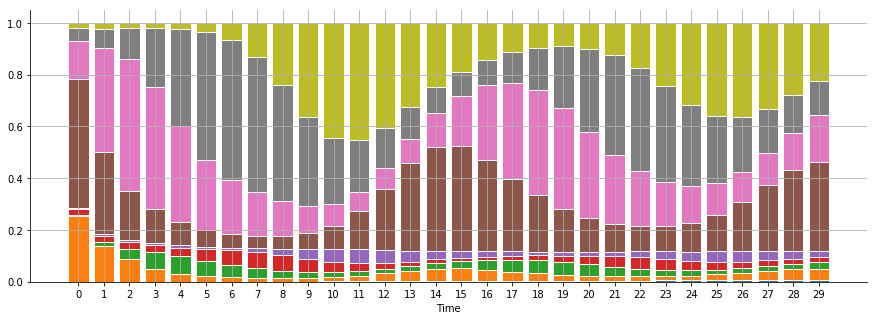

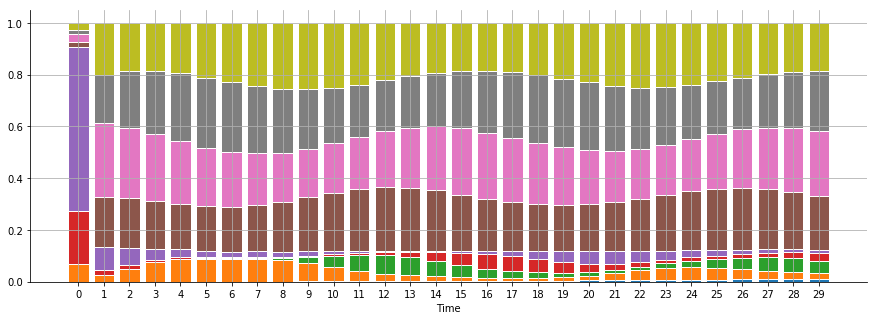

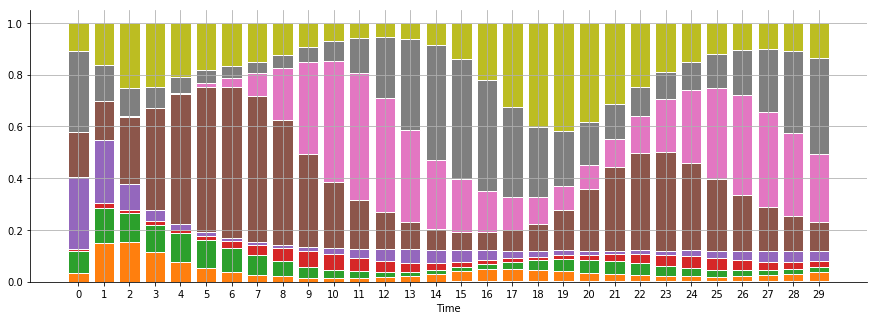

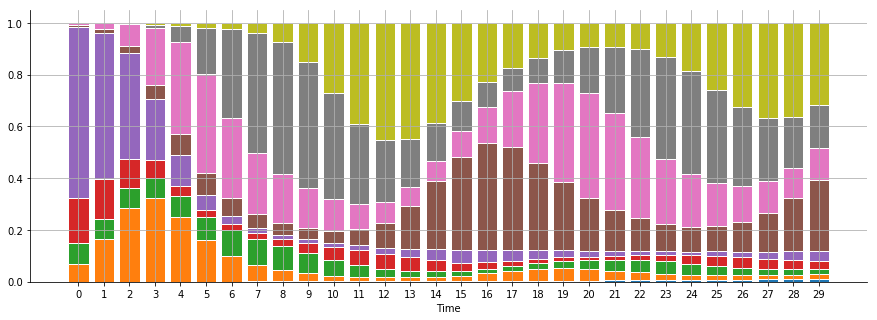

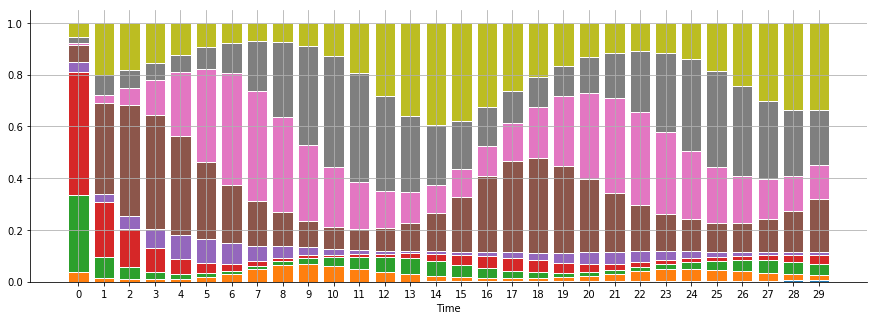

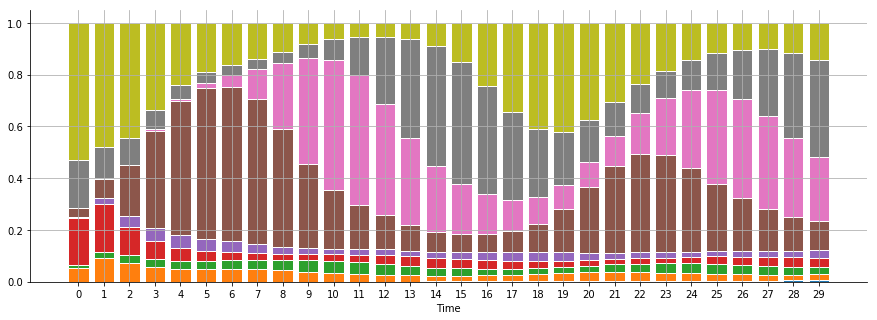

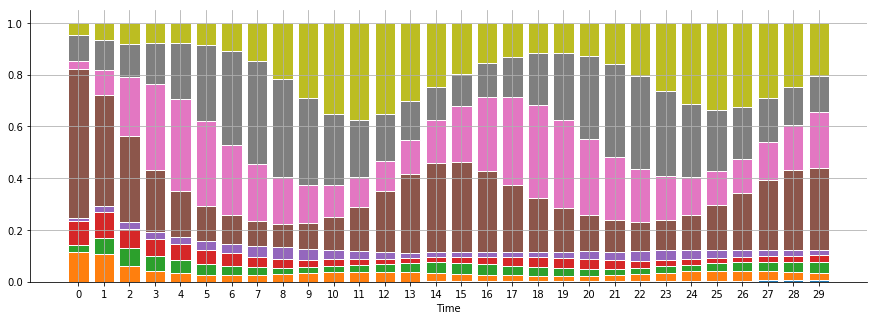

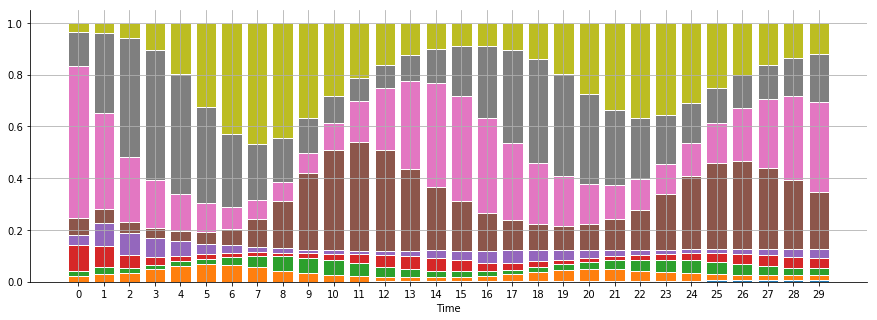

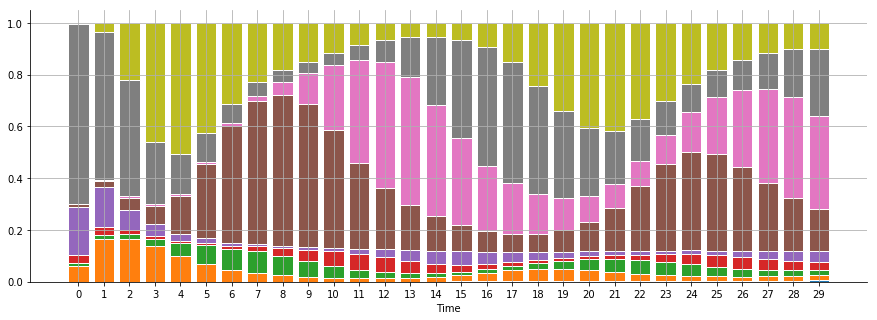

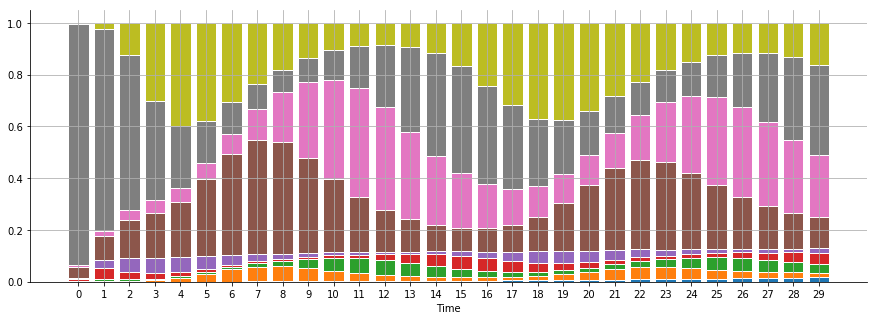

In [28]:
for i in range(10):
    plot_inputs_and_obs(inputs, masks, i)